# Computing the height of the intersection between the projective line $(x_0+x_1+x_2=0)\subset\mathbb{P}^2$ and its translate by a torsion point

### Roberto Gualdi and Martín Sombra

_Notebook run over SageMath 9.7_

## Abstract

This notebook provides the companion code of our paper "**Limit heights and special values of the Riemann zeta function**" [GS22], which studies the (canonical) height of the intersection point $P(\omega)$ of the projective plane lines

$$(x_0+x_1+x_2=0)\quad\text{ and }\quad (x_0+\omega_1^{-1}x_1+\omega_2^{-1}x_2=0)$$

as $\omega=(\omega_1,\omega_2)$ ranges in the set of nontrivial torsion points of the 2-dimensional multiplicative torus.

The major function defined in this notebook is `height_values`.
For a given positive integer $d$ and a positive real number $\varepsilon$, it
graphically displays the height of $P(\omega)$ for all nontrivial $d$-torsion points $\omega$, and
computes its average and the percentage of nontrivial $d$-torsion points for which the corresponding height lies in an $\varepsilon$-neighbourhood of the expected value given by [GS22, Corollary 3], which is

$$
\frac{2\zeta(3)}{3\zeta(2)}=0.487175\dots.
$$



We also define the function `evolution_averages` which, for a given positive integer $D$ and a positive real number $\varepsilon$, plots the behaviour for $2\le d\le D$ of the average of the height values corresponding to the nontrivial $d$-torsion points, and the percentage of them lying in an $\varepsilon$-neighbourhood of the expected value.

## The code

### Initialization

We start by setting the floating-point system on which the code will run, defining some necessary constants, and importing the Python library `random` that will be used to shuffle the array of height values when producing one of our graphical results.

In [1]:
RR = RealField(30)
CC = ComplexField(30)

i = CC(i)
pi = RR(pi)

import random

### The height of a point

Next we code the function `H(d,a,b)` computing the height values we are interested in.
Fix a positive integer $d$ and let $\zeta$ be a primitive $d$-th root of unity. For a given pair of integers 
$a,b\in\{0,\ldots,d-1\}$ with $(a, b)\neq(0,0)$, the function computes the height of the projective point

$$
P(\zeta^a,\zeta^b).
$$

This value does not depend the choice of $\zeta$ among the primitive $d$-th roots of unity, because of
the invariance of the height under Galois conjugation [BG06, Proposition 1.5.17].

To compute the height of the mentioned point we use its explicit expression from [GS22, Lemma 2.3 and Corollary 3.4], that is 

$$
\text{h}(P(\zeta^a,\zeta^b))=-\frac{\Lambda(e)}{\varphi(e)}+\frac{1}{\varphi(e)}\sum_{\substack{k=1,\ldots,e\\(k,e)=1}} \log \max \big(\big|e^{2\pi ibk/d}-e^{2\pi iak/d}\big|, \big|e^{2\pi ibk/d}-1\big|,\big|e^{2\pi iak/d}-1\big|\big),
$$

where $e=d/\gcd(a,b,d)$ is the order of the torsion point $(\zeta^a,\zeta^b)$, $\varphi$ the Euler totient function, and $\Lambda$ the von Mangoldt function.


In [2]:
# G(e) computes the first term in the formula for the height of the projective point P(zeta^a,zeta^b)

def G(e):      
    a = is_prime_power(e, get_data=True)
    p = a[0]
    k = a[1]
    if k == 0:
        return 0
    else:
        return -log(p)/(p^(k-1)*(p-1))

# F(d,a,b,k) gives the k-th term of the sum in the height formula

def F(d,a,b,k):
    return log( max( abs(exp(2*pi*i*b*k/d) - exp(2*pi*i*a*k/d)), abs(exp(2*pi*i*b*k/d) - 1), abs(exp(2*pi*i*a*k/d) - 1) ) )

# H(d,a,b) computes the height of P(zeta^a,zeta^b) using the functions G and F defined above.
# The Euler function of e is tracked by the variable Phi, whose final value is precisely \varphi(e)

def H(d,a,b):  
    Phi = 0 
    S = 0
    e =  d/gcd([a,b,d])    
    for k in [1..e-1]:
        if gcd(k,e) == 1:
            Phi = Phi + 1
            S = S + F(d,a,b,k)
    return G(e) + (S/Phi)

### The function `height_values`

We are now ready to define the main function of the code. For a given positive integer $d$, it computes the height values corresponding to all the nontrivial $d$-torsion points of the $2$-dimensional multiplicative torus, and produces numerical and graphical results based on them. 

By allowing an optional argument, we provide two ways to use this function. 

Calling `height_values(d,epsilon)` for an integer $d\geq2$ and a real number $\varepsilon>0$, it outputs a vector of length two.

* The first entry is the average

  $$\frac{1}{d^2-1} \sum_{\omega} \text{h}(P(\omega)),$$
  
  the sum being over the nontrivial $d$-torsion points.


* The second entry is the percentage of such torsion points $\omega$ for which
    
$$\bigg|\,\text{h}(P(\omega))-\frac{2\zeta(3)}{3\zeta(2)}\,\bigg|<\varepsilon.$$

Calling `height_values(d,epsilon,show_graph=True)` for an integer $d\geq2$ and a real number $\varepsilon>0$, the function produces two figures besides printing the information above.

* The first figure plots, in no particular order, the height of $P(\omega)$ for $\omega$ ranging in the set of nontrivial $d$-torsion points. A red mark indicates the expected average value
  
  $$\frac{2\zeta(3)}{3\zeta(2)}=0.487175\dots$$
  
  while an orange one shows the logarithmic Mahler measure of the polynomial $x_0+x_1+x_2$, whose numerical value $0.323061\dots$ is taken from [Boy81, display (14)].


* The second figure plots these height values arranged in a square grid. Fix a primitive $d$-th root of unity $\zeta$. For each pair of integers $a,b\in\{0,\ldots,d-1\}$ with $(a, b)\neq(0,0)$, the square cell in the position $(a,b)$ is associated to the nontrivial $d$-torsion point $(\zeta^a,\zeta^b)$, and colored with a tone of grey that is as dark as the value
$$\text{h}(P(\zeta^a,\zeta^b))$$

    is high. White cells corresponds to the value 0 and black ones to the value $\log(2)=0.693147\dots$, which are the extrema of these values [GS22, Proposition 2.2]. As already remarked, the final plot does not depend on the choice of the primitive $d$-th root of unity $\zeta$, thanks to the invariance of the height under Galois conjugation.

#### On the computation of the square grid

In practice, the code computes a $d\times d$ matrix $A$ with entries

$$
A_{a,b}:=
\begin{cases}
\text{h}(P(\zeta^{a},\zeta^{b}))&\text{for } a,b=0,\ldots,d-1 \text{ with } (a,b)\neq(0,0)
\\0& \text{for } a,b=0
\end{cases}
$$

for a primitive $d$-th root of unity $\zeta$. For convenience, we also collect the entries of $A$, except for $A_{0,0}$, in a vector $v$ of length $d^2-1$.

We next explain how we optimized the computation of $A$.
To start with, we know from [GS, Proposition 2.2] that the height of $P(\zeta^a,\zeta^b)$ vanishes when either $a=0$, $b=0$ or $a=b$. Therefore, we can restrict the computation to the cases

$$
a,b\in\{1,\ldots,d-1\}\quad\text{ and }\quad b\ne a.
$$

Moreover, the fact that the height is invariant under Galois conjugation can be exploited to propagate a single computation to several entries of $A$. Indeed, for each $a$ and $b$ we have that

$$P(\zeta^a,\zeta^b)=P\big(\xi^{a/\gcd(a,b,d)},\xi^{b/\gcd(a,b,d)}\big),$$

where $\xi=\zeta^{\gcd(a,b,d)}$ is a primitive root of unity of order $e=d/\gcd(a,b,d)$.
Hence its Galois conjugates are precisely the points

$$
P\big(\xi^{ka/\gcd(a,b,d)},\xi^{kb/\gcd(a,b,d)}\big)=P(\zeta^{ka},\zeta^{kb})
\quad \text{ for } k\in(\mathbb{Z}/e\mathbb{Z})^\times,
$$

and all of them have the same height. 

In [3]:
def height_values(d, epsilon,**kwargs):

# 1. PROLOGUE
    
    # We initialize the variables

    A = matrix(RR,d)
    v = vector(RR,d^2-1)
    j = 0
    graphic = False

    # We check if the user wants a graphical result

    for keyword, value in kwargs.items():
        if keyword == 'show_graph':
            if value == True:
                graphic = True
                
# 2. COMPUTING THE MATRIX A AND THE VECTOR v

    # To fill in the matrix with the values of the height, it suffices to consider the entries 
    # with nonzero coordinates and not lying on the diagonal

    for a in [1..d-1]:
        for b in [1..a-1,a+1..d-1]:

    # We compute the height of the projective point P(zeta^a,zeta^b) only if it has not been 
    # yet calculated otherwise

            if A[a,b] == 0:
            
                A[a,b] = H(d,a,b)
                
    # We exploit the Galois invariance to propagate this height computation
                
                e = d/gcd([a,b,d])
                for k in [1..e-1]:
                    if gcd(k,e) == 1:
                        A[Mod(k*a,d),Mod(k*b,d)] = A[a,b]
            
    # We add the value just computed to the vector v
            
            v[j] = A[a,b]
            j = j + 1
            
# 3. NUMERICAL OUTPUTS

    # We compute the average of the height values corresponding to the nontrivial d-torsion points

    average = sum(v)/(d^2-1)
    
    # We count how many of these height values are at distance at most epsilon from the expected value
    
    expectedaverage = n(2*zeta(3)/(3*zeta(2)))
    counter = 0
    for j in [0..d^2-2]:
        if abs(v[j]-expectedaverage) < epsilon:
            counter = counter + 1
    percent = n(counter*100/(d^2-1))
    
# 4. GRAPHICAL OUTPUTS

    # If the user does not desire any graphical result, the code outputs the computed average 
    # and percentage

    if graphic == False:
        return [average, percent]

    # Else it produces the required figures

    else:
        
        # First it prints out the basic numerical information
        
        print('d =',d)
        print('Maximum of height values:', max(v))
        print('Average of height values:', average)  
        print('For', percent,'% of the points, the height is closer to the average than', epsilon,'.')
        
    # FIGURE 1
        
        # A red horizontal segment marks the expected height value
    
        l1 = line([(0.9,expectedaverage),(1.05,expectedaverage)], color='red', thickness=2)
        
        # An orange horizontal segment marks the logarithmic Mahler measure of the polynomial 
        # x_0+x_1+x_2
        
        mahler = log(1.38135) 
        l2 = line([(0.9,mahler),(1.05,mahler)], color='orange', thickness=2)
  
        # We randomly shuffle the entries of v for a better visual effect, and put the height 
        # values as ordinates of a collection p of points with abscissa in the interval [0,1],
        # plotting them with a thickness that depends on the number of points
        
        random.shuffle(v)
        w = [(j/(d^2-1), v[j]) for j in [0..d^2-2]] 
        thickness = max(1,120/d)
        p = points(w,size=thickness)
 
        g = p + l1 + l2
        g.show(xmin=0, xmax=1.1, ymin=0, ymax=0.75, ticks=[[], None])
        
    # FIGURE 2
        
        # We plot the matrix A with its origin on the left-bottom corner, coloring each cell with a
        # tone of grey that is as dark as the corresponding height value (white corresponds to the 
        # value 0 and black to the value log(2)=0.693147...)
     
        h = matrix_plot(A, frame=False, vmin=0, vmax=log(2), zorder=0, flip_y=False)
        
        
        # We draw the frame of the matrix, turning around the cell (0,0) to underline that it does not
        # correspond to any meaningful height value
        
        sq = line([(-0.5,+0.5),(+0.5,+0.5),(+0.5,-0.5),(d-0.5,-0.5),(d-0.5,d-0.5),(-0.5,d-0.5),(-0.5,+0.5)], color='black', thickness=1, axes=False)
        
        # Finally we show the result
        
        show(sq + h)

We test our function to produce a graphical visualization for a low value of $d$.

d = 30
Maximum of height values: 0.69314718
Average of height values: 0.47128239
For 47.3859844271413 % of the points, the height is closer to the average than 0.100000000000000 .


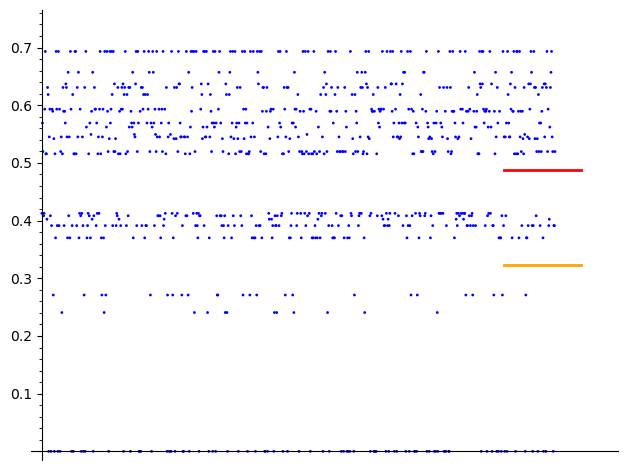

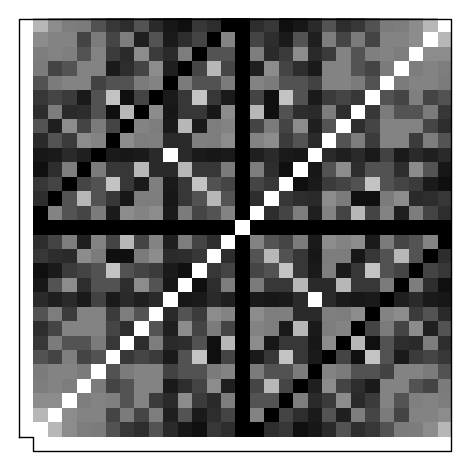

In [4]:
height_values(30, 0.1, show_graph=True)

Nothing prevents us from running the code for higher values of $d$ and finer values for $\varepsilon$, as we next do.

d = 200
Maximum of height values: 0.69314718
Average of height values: 0.48543270
For 42.9010725268132 % of the points, the height is closer to the average than 0.0100000000000000 .


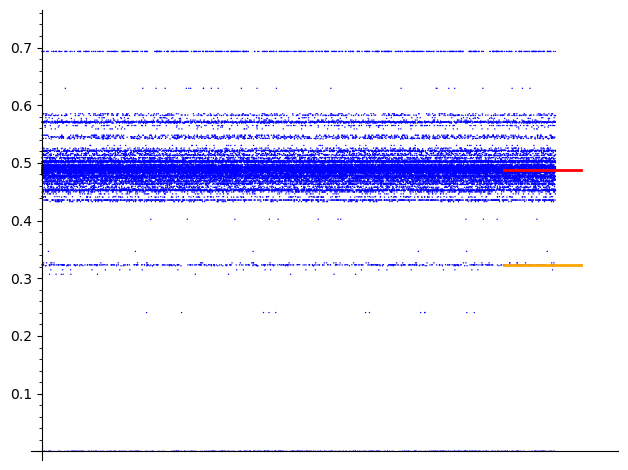

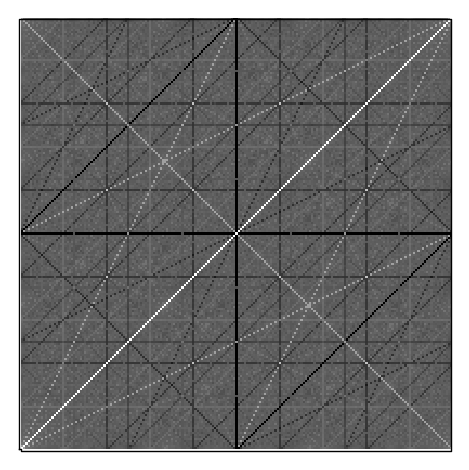

In [5]:
height_values(200, 0.01, show_graph=True)

### Asymptotics

Finally we define the function  `evolution_averages`, that pictures the evolution of the previous results for increasing values of $d$. It takes as input an integer $D\geq2$ and a positive real number $\varepsilon$, and plots the results of the function `height_values(d,epsilon)` for all $d\in\{2,\ldots, D\}$ and the given $\varepsilon$.

This results are shown in two different figures.

* The first shows the evolution of the averages of the height of $P(\omega)$ as $\omega$ ranges in the set of nontrivial $d$-torsion points, with a horizontal red line marking their limit value.

* The second exhibits the evolution of the percentage of nontrivial $d$-torsion points $\omega$ for which the height of $P(\omega)$ is closer than $\varepsilon$ to such limit value.

Since prime numbers are dear to number theorists, we color the results corresponding to prime values of $d$ in a darker shade of blue.

In [6]:
def evolution_averages(D, epsilon):
    
    # We initialize the vectors that will contain the results

    average_primes = []
    percent_primes = []
    average_non_primes = []
    percent_non_primes = []
    
    # We let d run from 2 to D and apply the function height_values to d and epsilon, storing the 
    # results in two different vectors for the prime and nonprime cases
    
    for d in [2..D]:
        
        a = height_values(d, epsilon)
        
        if d in Primes():
            
            average_primes.append([d,a[0]])
            percent_primes.append([d,a[1]])
            
        else:
            
            average_non_primes.append([d,a[0]])
            percent_non_primes.append([d,a[1]])
    
# FIGURE 1
    
    # We define a red horizontal segment marking the expected height value
    
    expectedaverage = n(2*zeta(3)/(3*zeta(2)))
    l = line([(0,expectedaverage),(D,expectedaverage)], color='red', thickness=2)
    
    # We draw the evolution of averages, coloring those corresponding to prime values of d in 'darkblue'
        
    p = points(average_non_primes, color='cyan') + points(average_primes,color='darkblue') + l
    p.show(title='Evolution of averages')
    
# FIGURE 2
    
    # This is the analogue of the previous figure for the evolution of the percentages
    
    q = points(percent_non_primes, color='lightskyblue') + points(percent_primes,color='darkblue')
    q.show(ymin=0, ymax=100, title='Evolution of percentages')

Here is the result when running the code for $D=250$ and $\varepsilon=0.1$.

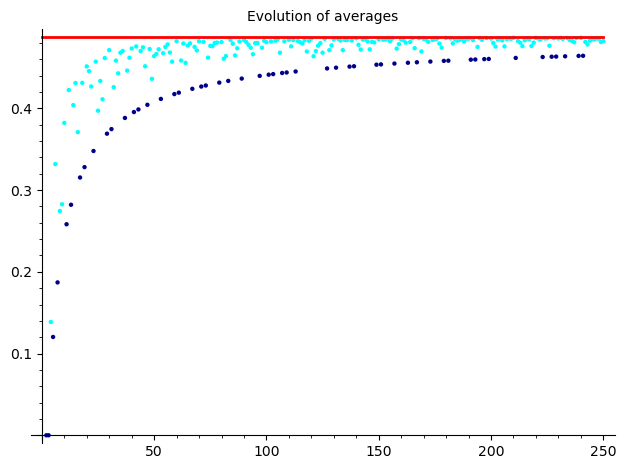

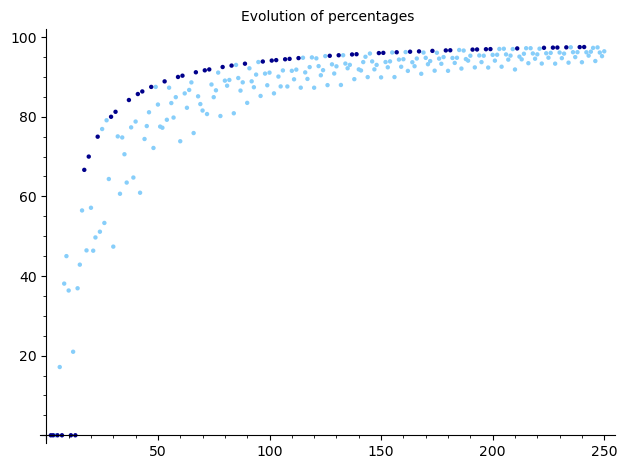

In [7]:
evolution_averages(250, 0.1)

In [GS, Section 8] we discuss extensively the numerical and graphical results produced by this code, in connection with the theoretical results, questions and conjectures in the paper.

## References

[BG06]    E. Bombieri and W. Gubler, ''_Heights in Diophantine geometry_'', New Math. Monogr., vol. 4, Cambridge Univ. Press, 2006.

[Boy81]   D. W. Boyd, ''_Speculations concerning the range of Mahler's measure_'', Canad. Math. Bull. 24:4 (1981), 453-469.

[GS22]     R. Gualdi and M. Sombra, ''_Limit heights and special values of the Riemann zeta function_'', arXiv preprint available at <https://arxiv.org>.